In [1]:
import warnings
from time import time

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from tools.common_methods import get_train_test_data, print_results

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
X_train, X_test, y_train, y_test = get_train_test_data()

In [3]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [4]:
n_estimators = 5000

In [5]:
best_gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=5000, max_features=12, random_state=1)
best_gbr.fit(X_train, y_train)

y_pred = best_gbr.predict(X_test)
print_results(y_test, y_pred)

MSE: 31.784449181512297 	R2 score: 0.9795161485729588


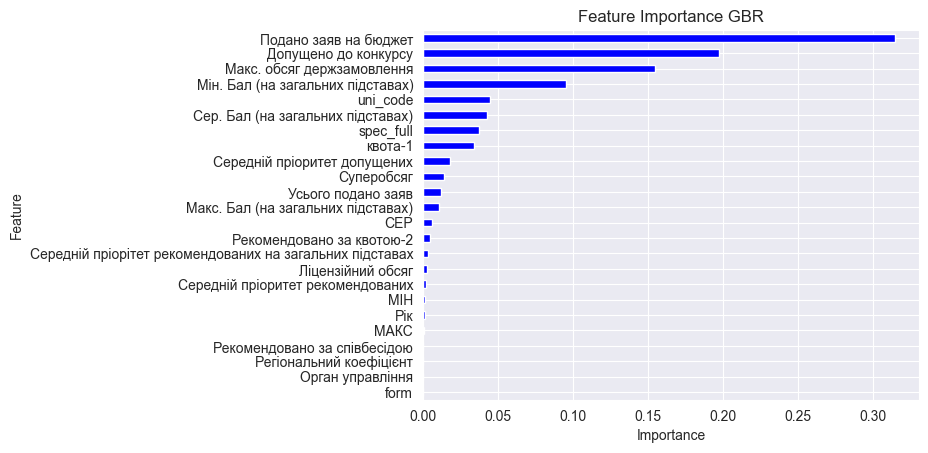

In [6]:
importances = pd.Series(best_gbr.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True, inplace=True)
importances.plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance GBR")
plt.show()

In [7]:
results_df = pd.DataFrame(columns=['Model', 'Amount of features', 'MSE', 'R2 Score'])
best_gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=n_estimators, random_state=1)
xgb_regressor = XGBRegressor(**joblib.load('../saved_models/xgb_regressor.sav').get_params())
best_lgbm = LGBMRegressor(**joblib.load('../saved_models/lgbm_regressor.sav').get_params())
best_random_forest = RandomForestRegressor(random_state=1, n_jobs=-1, n_estimators=151, max_depth=16)

for n in range(1, 25):
    start = time()
    n_best_features = importances.sort_values(ascending=False).head(n).keys()
    x_train_n_features = X_train.get(n_best_features)
    x_train_n_features_std = sc.fit_transform(x_train_n_features)

    x_test_n_features = X_test.get(n_best_features)
    x_test_n_features_std = sc.transform(x_test_n_features)

    best_gbr.fit(x_train_n_features_std, y_train)
    y_pred_gbr = best_gbr.predict(x_test_n_features_std)
    mse_gbr = mean_squared_error(y_test, y_pred_gbr)
    r2_gbr = r2_score(y_test, y_pred_gbr)
    results_df = results_df.append(
        {'Model': 'GradientBoostingRegressor', 'Amount of features': n, 'MSE': mse_gbr, 'R2 Score': r2_gbr},
        ignore_index=True)


    xgb_regressor.fit(x_train_n_features_std, y_train)
    y_pred_xgb = xgb_regressor.predict(x_test_n_features_std)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    results_df = results_df.append(
        {'Model': 'XGBRegressor', 'Amount of features': n, 'MSE': mse_xgb, 'R2 Score': r2_xgb},
        ignore_index=True)

    best_lgbm.fit(x_train_n_features_std, y_train)
    y_pred_lgbm = best_lgbm.predict(x_test_n_features_std)
    mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
    r2_lgbm = r2_score(y_test, y_pred_lgbm)
    results_df = results_df.append(
        {'Model': 'LGBMRegressor', 'Amount of features': n, 'MSE': mse_lgbm, 'R2 Score': r2_lgbm},
        ignore_index=True)

    best_random_forest.fit(x_train_n_features, y_train)
    y_pred_rf = best_random_forest.predict(x_test_n_features)
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    results_df = results_df.append(
        {'Model': 'RandomForestRegressor', 'Amount of features': n, 'MSE': mse_rf, 'R2 Score': r2_rf},
        ignore_index=True)

    print(n, '- time for the round:', time() - start)

1 - time for the round: 40.05038404464722
2 - time for the round: 66.1028642654419
3 - time for the round: 63.550405740737915
4 - time for the round: 116.64220142364502
5 - time for the round: 129.2626440525055
6 - time for the round: 175.77207159996033
7 - time for the round: 192.20796418190002
8 - time for the round: 195.89230704307556
9 - time for the round: 228.49292039871216
10 - time for the round: 231.19200491905212
11 - time for the round: 263.511102437973
12 - time for the round: 295.9383370876312
13 - time for the round: 315.00374722480774
14 - time for the round: 321.08864760398865
15 - time for the round: 337.9205286502838
16 - time for the round: 353.1070055961609
17 - time for the round: 374.5661458969116
18 - time for the round: 391.0359101295471
19 - time for the round: 399.3692903518677
20 - time for the round: 417.22387981414795
21 - time for the round: 419.3997530937195
22 - time for the round: 423.14141631126404
23 - time for the round: 390.8294665813446
24 - time f

In [15]:
results_df.to_csv('../readyDatasets/features_comparing_gbr.csv', index=False)
results_df

,Model,Amount of features,MSE,R2 Score
0,GradientBoostingRegressor,1,445.293606,0.713025
1,XGBRegressor,1,465.550426,0.699971
2,LGBMRegressor,1,588.787307,0.620549
3,RandomForestRegressor,1,423.145006,0.727299
4,GradientBoostingRegressor,2,385.493284,0.751564
...,...,...,...,...
91,RandomForestRegressor,23,53.166641,0.965736
92,GradientBoostingRegressor,24,36.845677,0.976254
93,XGBRegressor,24,34.263905,0.977918
94,LGBMRegressor,24,44.019164,0.971631


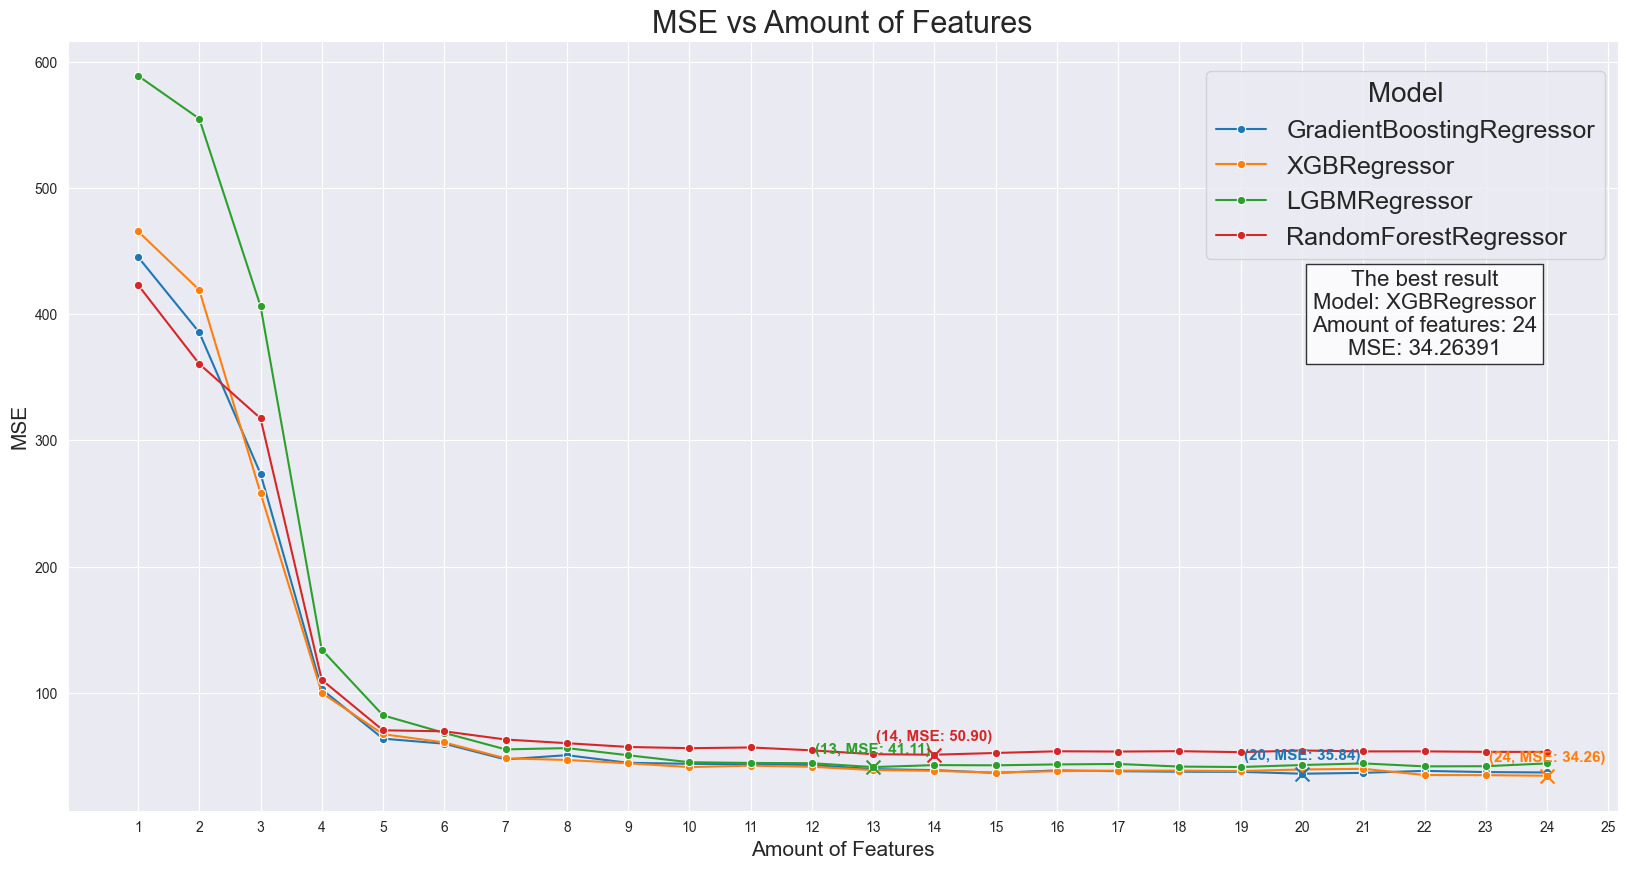

In [9]:
min_mse_indices = results_df.groupby('Model')['MSE'].idxmin()

model_colors = {model: color for model, color in zip(results_df['Model'].unique(), sns.color_palette("tab10", n_colors=len(results_df['Model'].unique())))}

plt.figure(figsize=(20, 10))
sns.lineplot(x='Amount of features', y='MSE', hue='Model', data=results_df, marker='o', palette=model_colors)

for index in min_mse_indices:
    model_color = model_colors[results_df.loc[index, 'Model']]
    plt.scatter(results_df.loc[index, 'Amount of features'], results_df.loc[index, 'MSE'],
                color=model_color, marker='x', s=100, zorder=5)

    plt.annotate(
        f"({results_df.loc[index, 'Amount of features']}, MSE: {results_df.loc[index, 'MSE']:.2f})",
        xy=(results_df.loc[index, 'Amount of features'], results_df.loc[index, 'MSE']),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        color=model_color,
        size='11',
        weight='bold'
    )

plt.xticks(range(1, 26))
plt.title('MSE vs Amount of Features', size=22)
plt.xlabel('Amount of Features', size=15)
plt.ylabel('MSE', size=15)
plt.legend(title='Model', bbox_to_anchor=(1, 0.7), loc='lower right', fontsize=18, title_fontsize=20)
plt.grid(True)

absolute_winner_index = results_df['MSE'].idxmin()
winner_info = f"The best result\n" \
              f"Model: {results_df.loc[absolute_winner_index, 'Model']}\n" \
              f"Amount of features: {results_df.loc[absolute_winner_index, 'Amount of features']}\n" \
              f"MSE: {results_df.loc[absolute_winner_index, 'MSE']:.5f}"
plt.text(22, 400, winner_info, ha='center', va='center', fontsize=16,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.show()

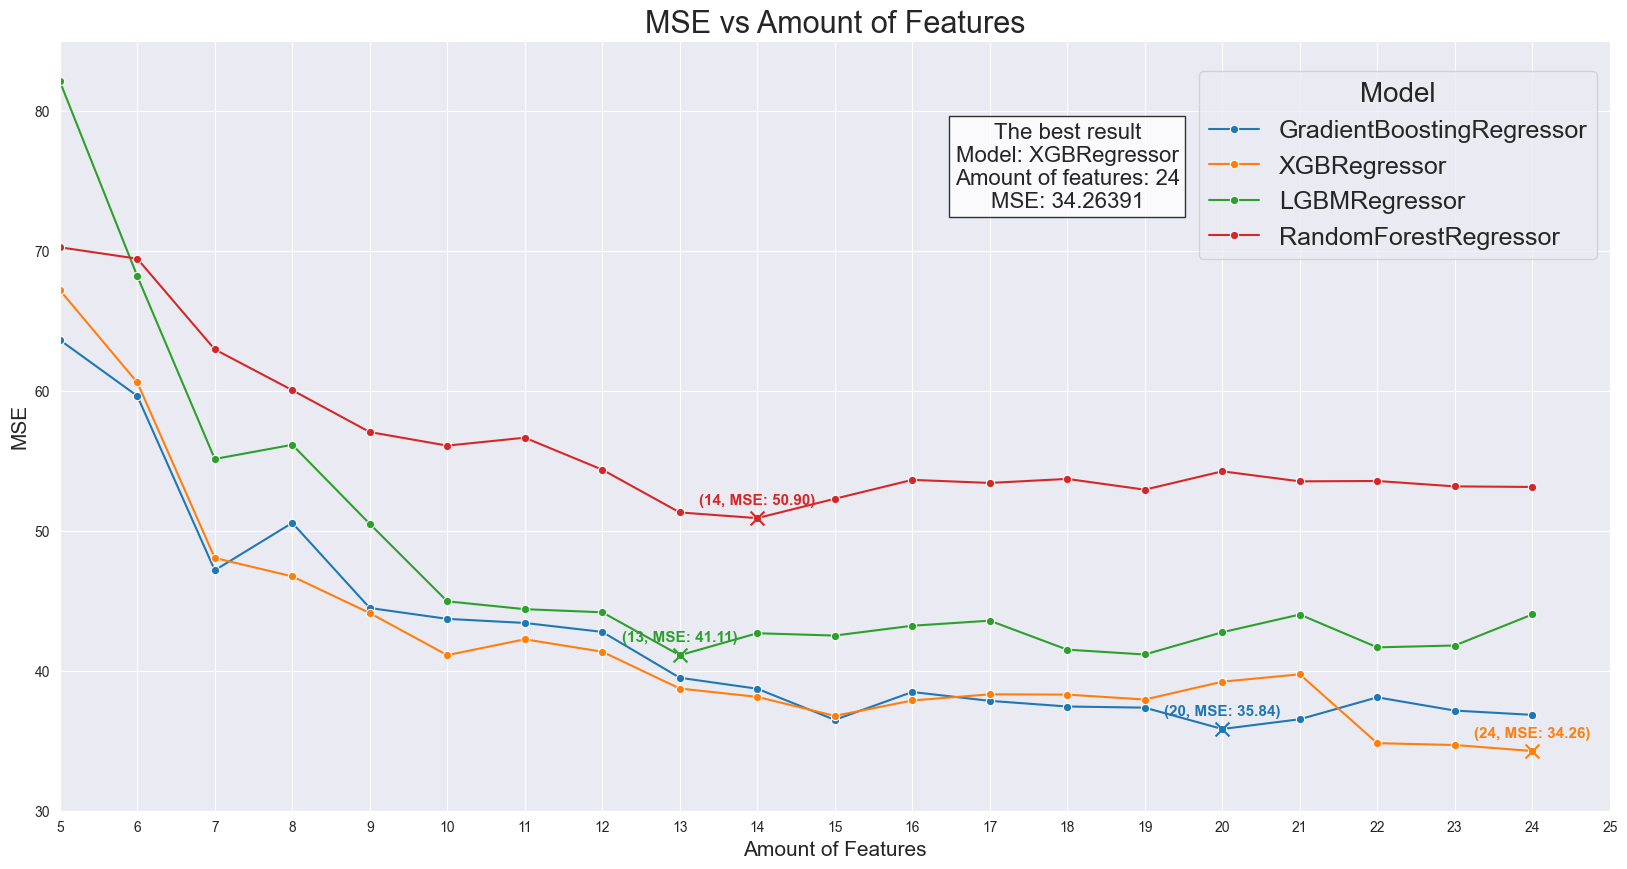

In [10]:
min_mse_indices = results_df.groupby('Model')['MSE'].idxmin()

model_colors = {model: color for model, color in zip(results_df['Model'].unique(), sns.color_palette("tab10", n_colors=len(results_df['Model'].unique())))}

plt.figure(figsize=(20, 10))
sns.lineplot(x='Amount of features', y='MSE', hue='Model', data=results_df, marker='o', palette=model_colors)

for index in min_mse_indices:
    model_color = model_colors[results_df.loc[index, 'Model']]
    plt.scatter(results_df.loc[index, 'Amount of features'], results_df.loc[index, 'MSE'],
                color=model_color, marker='x', s=100, zorder=5)

    plt.annotate(
        f"({results_df.loc[index, 'Amount of features']}, MSE: {results_df.loc[index, 'MSE']:.2f})",
        xy=(results_df.loc[index, 'Amount of features'], results_df.loc[index, 'MSE']),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        color=model_color,
        size='11',
        weight='bold'
    )

plt.xticks(range(1, 26))
plt.xlim(5, 25)
plt.ylim(30,85)
plt.title('MSE vs Amount of Features', size=22)
plt.xlabel('Amount of Features', size=15)
plt.ylabel('MSE', size=15)
plt.legend(title='Model', bbox_to_anchor=(1, 0.7), loc='lower right', fontsize=18, title_fontsize=20)
plt.grid(True)

absolute_winner_index = results_df['MSE'].idxmin()
winner_info = f"The best result\n" \
              f"Model: {results_df.loc[absolute_winner_index, 'Model']}\n" \
              f"Amount of features: {results_df.loc[absolute_winner_index, 'Amount of features']}\n" \
              f"MSE: {results_df.loc[absolute_winner_index, 'MSE']:.5f}"
plt.text(18, 76, winner_info, ha='center', va='center', fontsize=16,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.show()

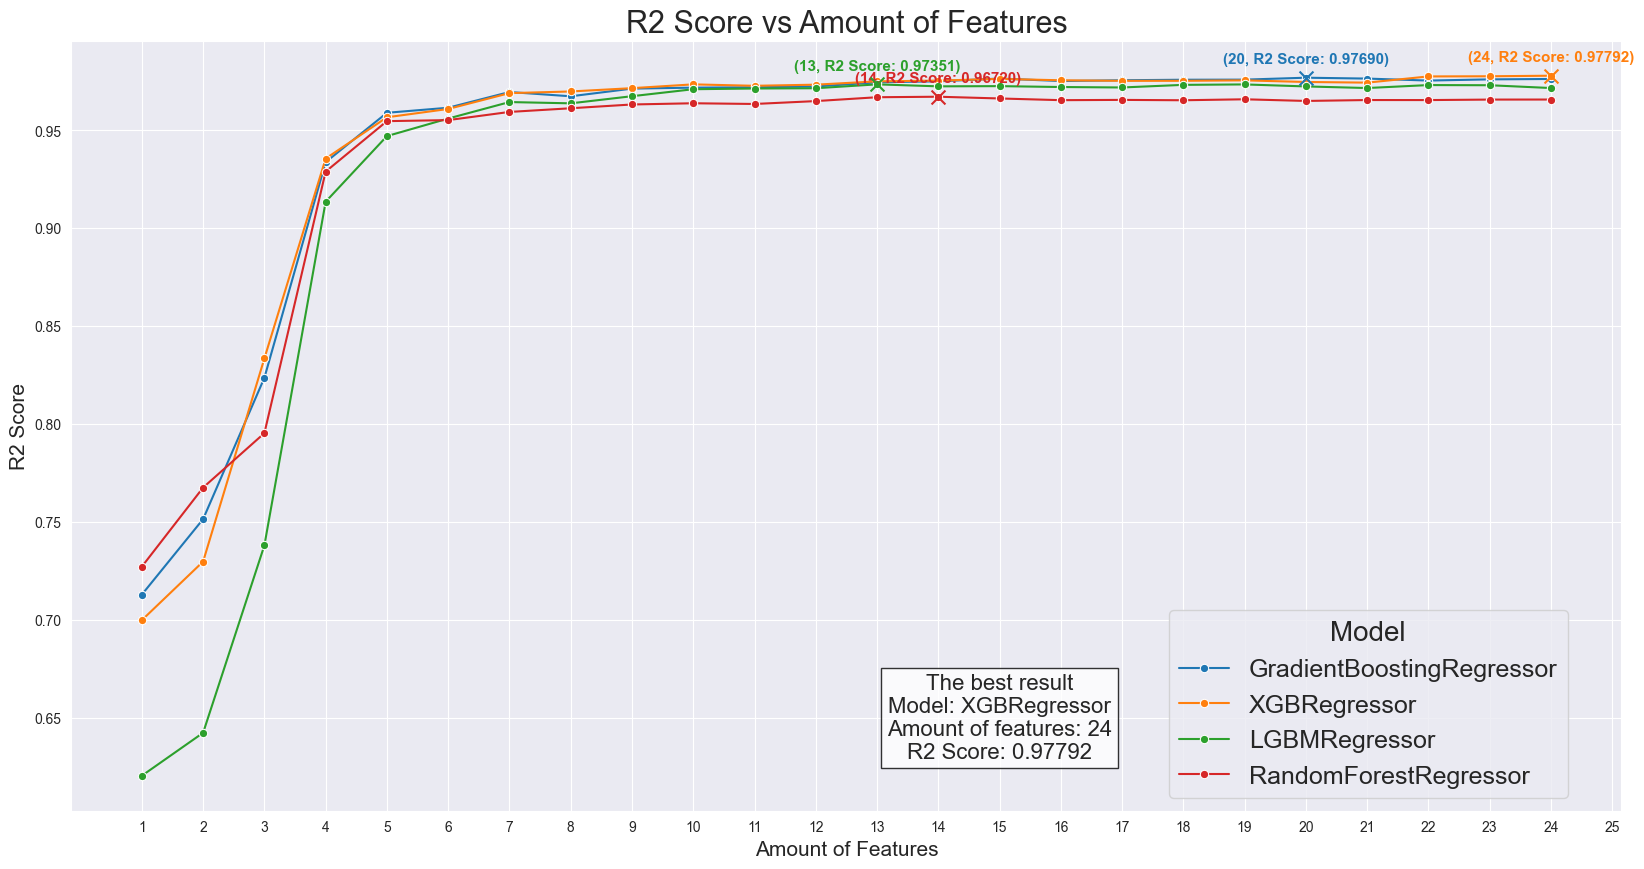

In [14]:
max_r2_indices = results_df.groupby('Model')['R2 Score'].idxmax()

model_colors = {model: color for model, color in zip(results_df['Model'].unique(), sns.color_palette("tab10", n_colors=len(results_df['Model'].unique())))}

plt.figure(figsize=(20, 10))
sns.lineplot(x='Amount of features', y='R2 Score', hue='Model', data=results_df, marker='o', palette=model_colors)

for index in max_r2_indices:
    model_color = model_colors[results_df.loc[index, 'Model']]
    plt.scatter(results_df.loc[index, 'Amount of features'], results_df.loc[index, 'R2 Score'],
                color=model_color, marker='x', s=100, zorder=5)

    plt.annotate(
        f"({results_df.loc[index, 'Amount of features']}, R2 Score: {results_df.loc[index, 'R2 Score']:.5f})",
        xy=(results_df.loc[index, 'Amount of features'], results_df.loc[index, 'R2 Score']),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        color=model_color,
        size='11',
        weight='bold'
    )

plt.xticks(range(1, 26))
plt.title('R2 Score vs Amount of Features', size=22)
plt.xlabel('Amount of Features', size=15)
plt.ylabel('R2 Score', size=15)
plt.legend(title='Model', bbox_to_anchor=(0.7, 0), loc='lower left', fontsize=18, title_fontsize=20)
plt.grid(True)

absolute_winner_index = results_df['R2 Score'].idxmax()
winner_info = f"The best result\n" \
              f"Model: {results_df.loc[absolute_winner_index, 'Model']}\n" \
              f"Amount of features: {results_df.loc[absolute_winner_index, 'Amount of features']}\n" \
              f"R2 Score: {results_df.loc[absolute_winner_index, 'R2 Score']:.5f}"
plt.text(15, 0.65, winner_info, ha='center', va='center', fontsize=16,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.show()

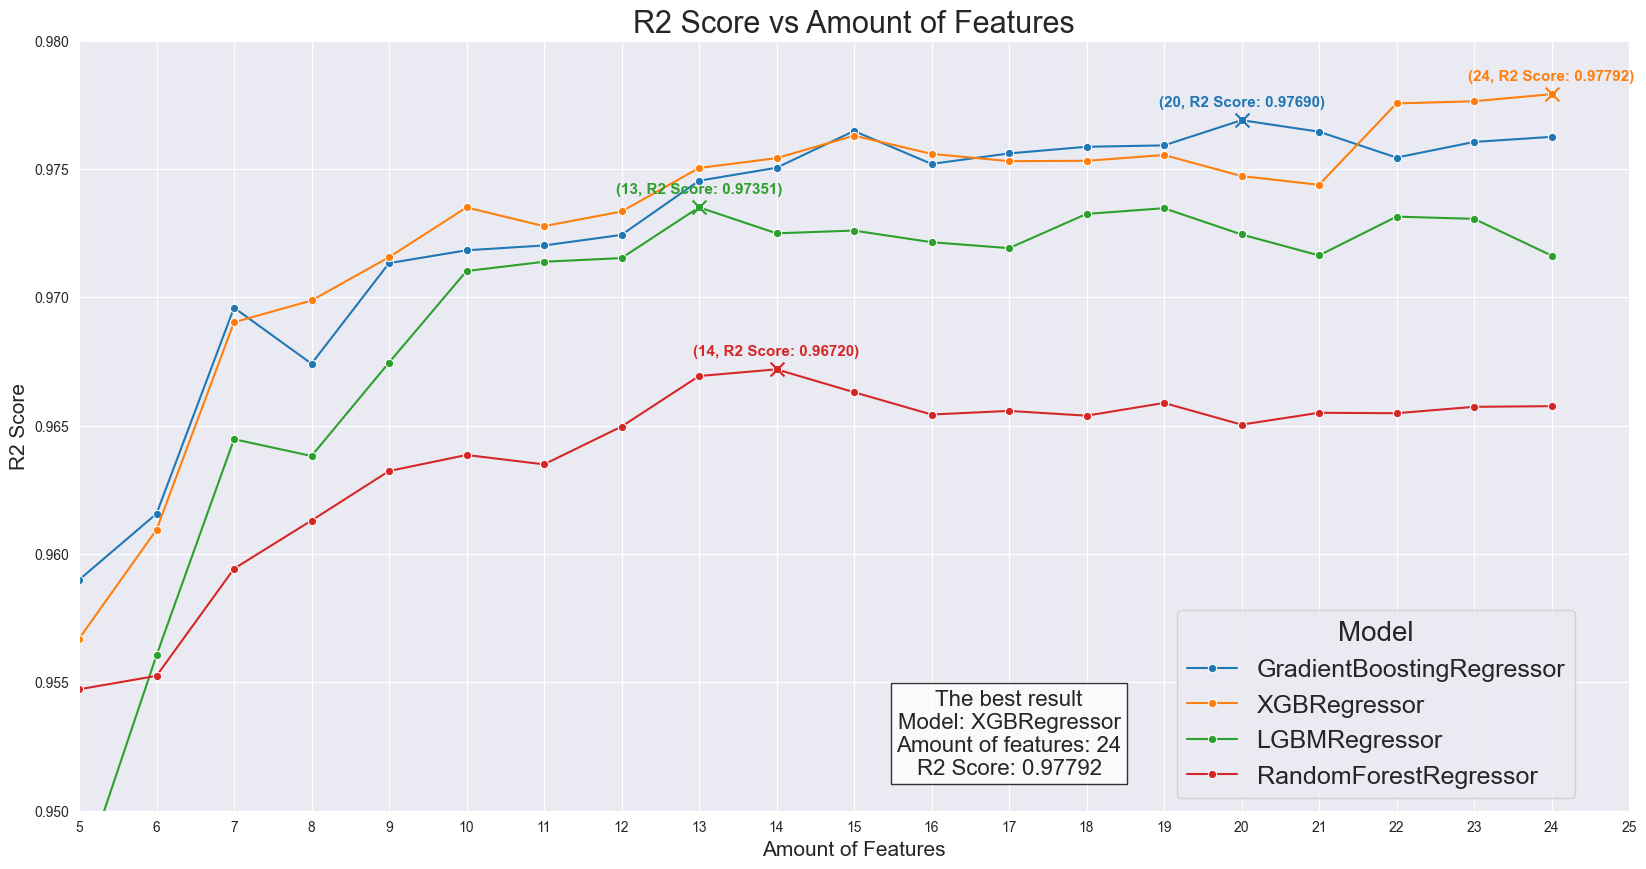

In [13]:
max_r2_indices = results_df.groupby('Model')['R2 Score'].idxmax()

model_colors = {model: color for model, color in zip(results_df['Model'].unique(), sns.color_palette("tab10", n_colors=len(results_df['Model'].unique())))}

plt.figure(figsize=(20, 10))
sns.lineplot(x='Amount of features', y='R2 Score', hue='Model', data=results_df, marker='o', palette=model_colors)

for index in max_r2_indices:
    model_color = model_colors[results_df.loc[index, 'Model']]
    plt.scatter(results_df.loc[index, 'Amount of features'], results_df.loc[index, 'R2 Score'],
                color=model_color, marker='x', s=100, zorder=5)

    plt.annotate(
        f"({results_df.loc[index, 'Amount of features']}, R2 Score: {results_df.loc[index, 'R2 Score']:.5f})",
        xy=(results_df.loc[index, 'Amount of features'], results_df.loc[index, 'R2 Score']),
        xytext=(0, 10),
        textcoords='offset points',
        ha='center',
        color=model_color,
        size='11',
        weight='bold'
    )

plt.xticks(range(1, 26))
plt.xlim(5, 25)
plt.ylim(0.95, 0.98)
plt.title('R2 Score vs Amount of Features', size=22)
plt.xlabel('Amount of Features', size=15)
plt.ylabel('R2 Score', size=15)
plt.legend(title='Model', bbox_to_anchor=(0.7, 0), loc='lower left', fontsize=18, title_fontsize=20)
plt.grid(True)

absolute_winner_index = results_df['R2 Score'].idxmax()
winner_info = f"The best result\n" \
              f"Model: {results_df.loc[absolute_winner_index, 'Model']}\n" \
              f"Amount of features: {results_df.loc[absolute_winner_index, 'Amount of features']}\n" \
              f"R2 Score: {results_df.loc[absolute_winner_index, 'R2 Score']:.5f}"
plt.text(17, 0.953, winner_info, ha='center', va='center', fontsize=16,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.show()